In [1]:
import pandas as pd
import os
import sys

ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), '..'))
if ROOT_DIR not in sys.path:
    sys.path.insert(0, ROOT_DIR)

from packages.utils import cloud_cnxn, seasons, season_conversion
c_con, c_eng = cloud_cnxn()
seasons = seasons()

Number of games: 1230
t-Statistic: 3.946; p-value: 0.000
Cohen's d (effect): 0.113


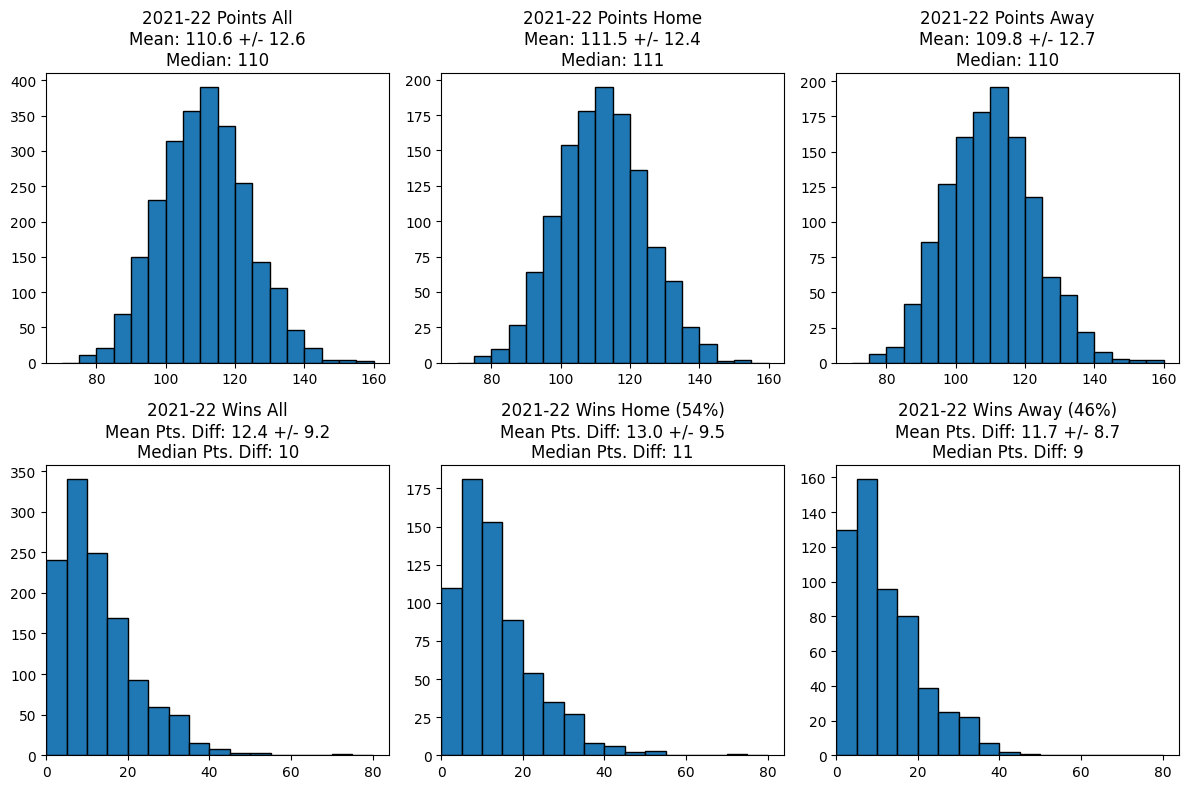


Number of games: 1230
t-Statistic: 6.414; p-value: 0.000
Cohen's d (effect): 0.183


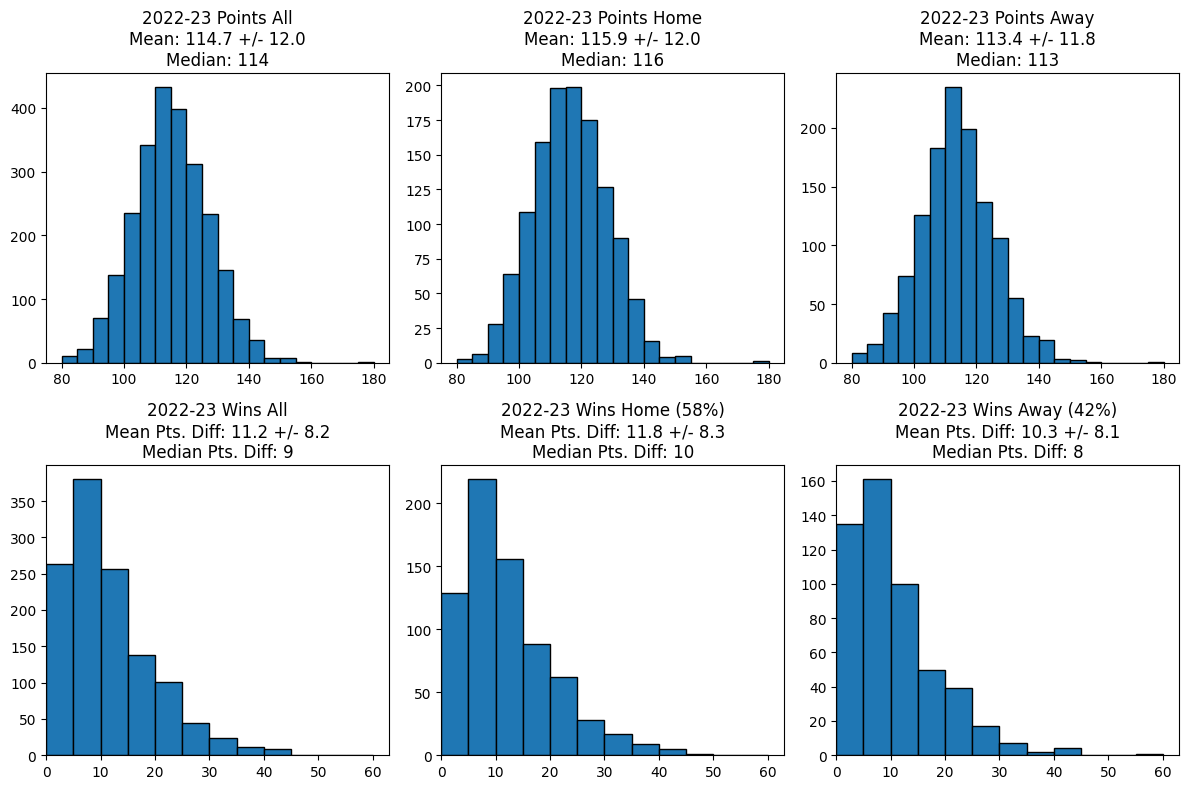


Number of games: 1230
t-Statistic: 4.812; p-value: 0.000
Cohen's d (effect): 0.137


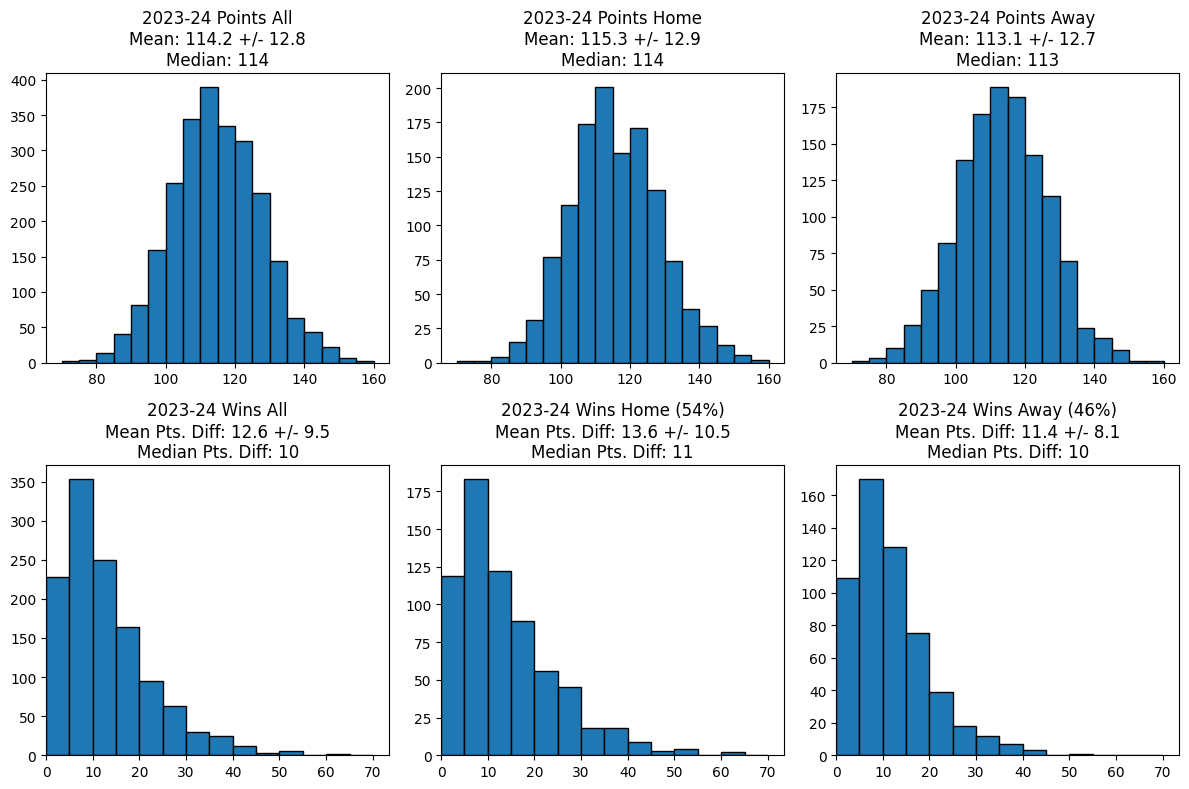


Number of games: 1230
t-Statistic: 3.604; p-value: 0.000
Cohen's d (effect): 0.103


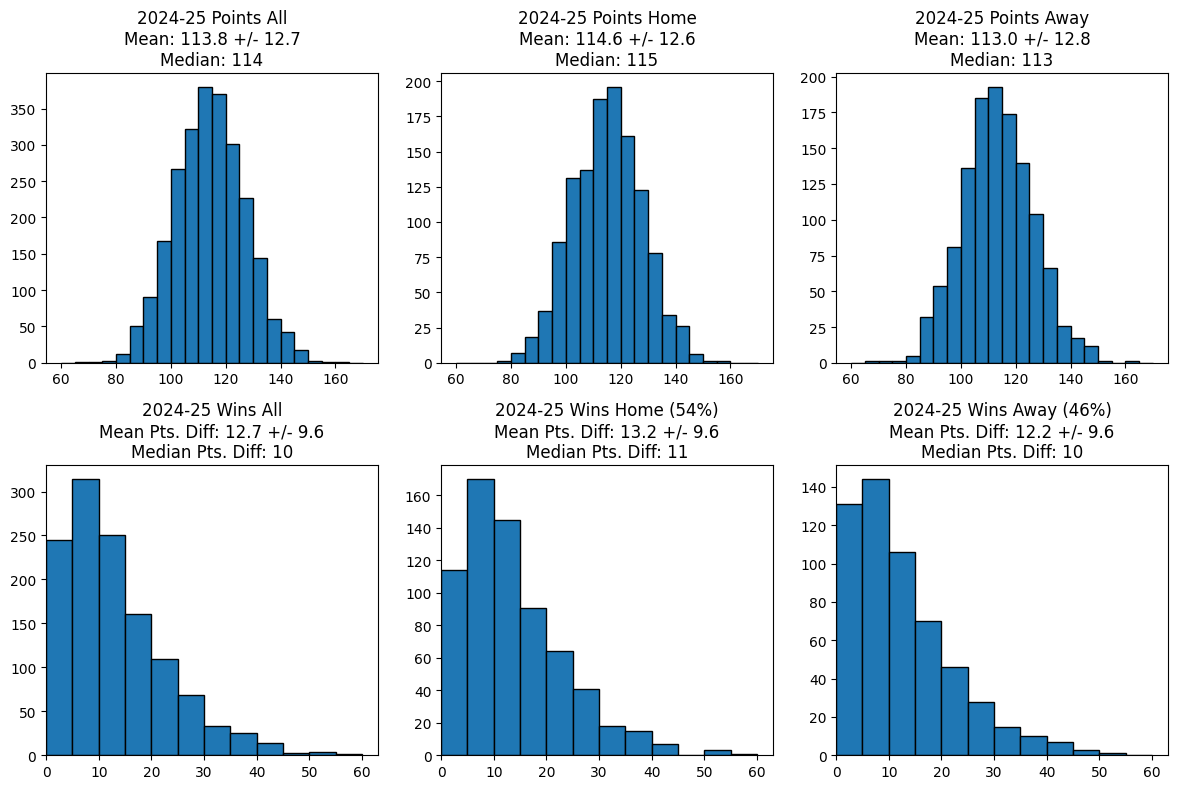


Number of games: 28
t-Statistic: 0.276; p-value: 0.785
Cohen's d (effect): 0.052


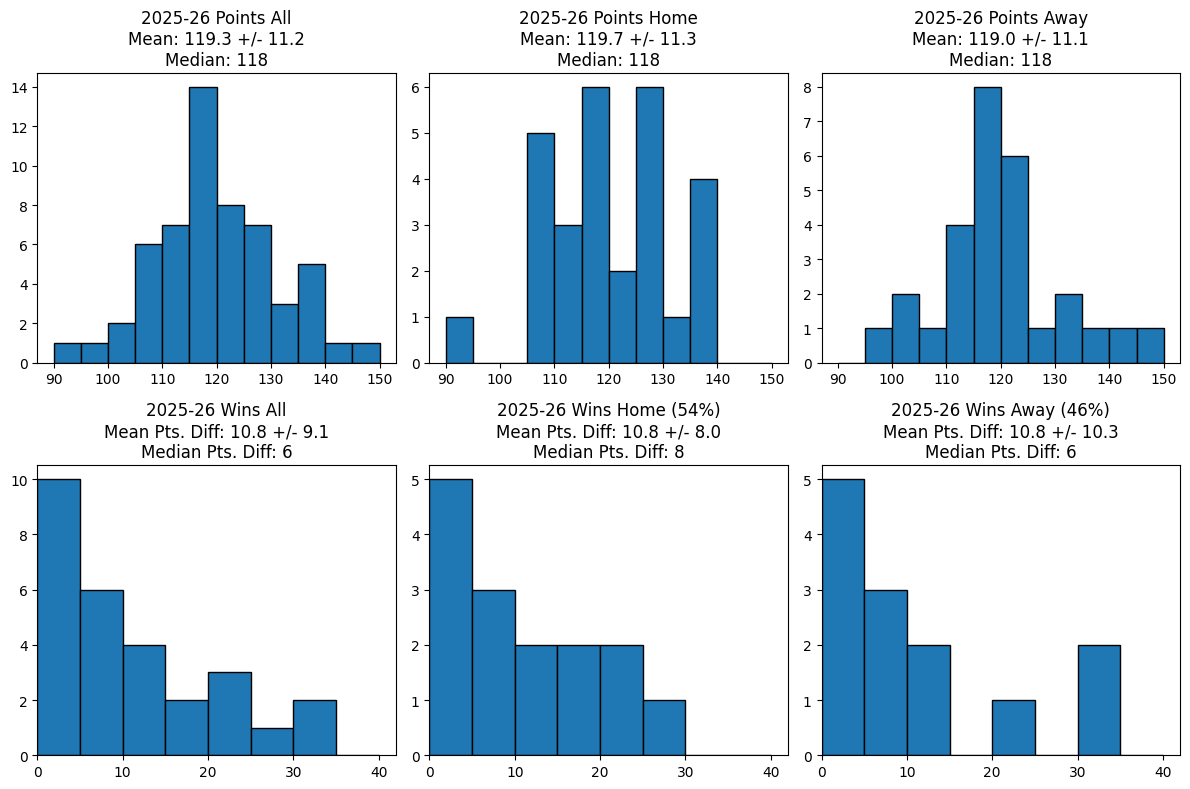

In [2]:
# A describe().T with season_all, season_home, season_away as the index
# Each one will probably have to be independently calculated and appended
import math as m
import matplotlib.pyplot as plt
import numpy as np

df_dict = {}

for season in seasons:
    schema = season_conversion(season)
    # Query data
    sch = pd.read_sql_query(f"""select *
                            from "{schema}".game_details where home_pts is not null
                            and game_id != '0062400001'
                            """,con=c_eng)
    sch = sch[ (sch["game_type"]=="Regular Season") | (sch["game_type"]=="Emirates NBA Cup") ]
    sch.sort_values("game_time",inplace=True)    # Sort by date, preserve time order
    df_dict[schema] = sch  
    print(f"Number of games: {len(sch)}")
    
    stat_list = []
    home_list = []
    away_list = []

    for game in sch.index:
        # Event-dependent assignments
        home_stat = sch.loc[game,"home_pts"]               # Assign home
        away_stat = sch.loc[game,"away_pts"]               # Assign away

        home_list.append(home_stat)
        away_list.append(away_stat)
        stat_list.append(home_stat)     # For 
        stat_list.append(away_stat)

    max_stat = max(stat_list)
    min_stat = min(stat_list)
    
    limit_low = m.floor(min_stat/10) * 10
    limit_high = m.ceil(max_stat/10) * 10
    bins = int((limit_high - limit_low) / 5)

    # Test for significance between home/away means
    # Paired t-test, so difference is measured at every i-position in each list
    # Since the mean of differences is divided by std of differences, small std can make t-statistic large
    from scipy.stats import ttest_rel
    t_stat, p_val = ttest_rel(home_list, away_list)
    print(f"t-Statistic: {t_stat:.3f}; p-value: {p_val:.3f}")
    
    # Effect size
    # Cohen's d measures practical significance small < .2 < .6 < .8 < big
    # How many stds apart the means are
    diffs = np.array(home_list) - np.array(away_list)
    cohens_d = np.mean(diffs) / np.std(diffs, ddof=1)
    print(f"Cohen's d (effect): {cohens_d:.3f}")
    
    # Plot histograms
    fig, axes = plt.subplots(2, 3, figsize=(12,8))
    axes[0, 0].hist(stat_list,
                 range=[limit_low, limit_high],
                 bins=bins,
                 edgecolor="black",
                 linewidth=1)
    axes[0, 0].set_title(f"{season} Points All\nMean: {round(np.mean(stat_list),1)} +/- {round(np.std(stat_list),1)}\nMedian: {int(np.median(stat_list))}")
    
    axes[0, 1].hist(home_list,
                 range=[limit_low, limit_high],
                 bins=bins,
                 edgecolor="black",
                 linewidth=1)
    axes[0, 1].set_title(f"{season} Points Home\nMean: {round(np.mean(home_list),1)} +/- {round(np.std(home_list),1)}\nMedian: {int(np.median(home_list))}")
  
    axes[0, 2].hist(away_list,
                 range=[limit_low, limit_high],
                 bins=bins,
                 edgecolor="black",
                 linewidth=1)
    axes[0, 2].set_title(f"{season} Points Away\nMean: {round(np.mean(away_list),1)} +/- {round(np.std(away_list),1)}\nMedian: {int(np.median(away_list))}")  

    # Wins
    # Each row is at the game-level, meaning there is a win in each row
    # The calculation is home - away, so away wins will always be negative
    # This returns point differential for all wins
    all_wins = [abs(val) for val in diffs] 
    max_wins = max(all_wins)
    min_wins = min(all_wins)
    
    limit_low = m.floor(min_wins/10) * 10
    limit_high = m.ceil(max_wins/10) * 10
    bins = int((limit_high - limit_low) / 5)
    
    axes[1, 0].hist(all_wins,
                 range=[0, limit_high],
                 bins=bins,
                 edgecolor="black",
                 linewidth=1)
    axes[1, 0].set_title(f"{season} Wins All\nMean Pts. Diff: {round(np.mean(all_wins),1)} +/- {round(np.std(all_wins),1)}\nMedian Pts. Diff: {int(np.median(all_wins))}")
    axes[1, 0].set_xlim(left=0)

    home_wins = [abs(val) for val in diffs if val > 0]
    h_win_p = int(round(100 * len(home_wins) / len(all_wins), 0))
    axes[1, 1].hist(home_wins,
                 range=[0, limit_high],
                 bins=bins,
                 edgecolor="black",
                 linewidth=1)
    axes[1, 1].set_title(f"{season} Wins Home ({h_win_p}%)\nMean Pts. Diff: {round(np.mean(home_wins),1)} +/- {round(np.std(home_wins),1)}\nMedian Pts. Diff: {int(np.median(home_wins))}")
    axes[1, 1].set_xlim(left=0)
  
    away_wins = [abs(val) for val in diffs if val < 0]
    a_win_p = int(round(100 * len(away_wins) / len(all_wins), 0))
    axes[1, 2].hist(away_wins,
                 range=[0, limit_high],
                 bins=bins,
                 edgecolor="black",
                 linewidth=1)
    axes[1, 2].set_title(f"{season} Wins Away ({a_win_p}%)\nMean Pts. Diff: {round(np.mean(away_wins),1)} +/- {round(np.std(away_wins),1)}\nMedian Pts. Diff: {int(np.median(away_wins))}")
    axes[1, 2].set_xlim(left=0)
    
    plt.tight_layout()
    plt.show()

    
    print()

###### In terms of points-scored, home teams have a SLIGHT advantage every season
###### The difference is statistically significant in the paired t-test, meaning, the difference is consistent
###### All effect sizes are small < .2, meaning the difference is not practically significant
###### Home teams consistently win ~54% of games, this will be interesting to compare with h2h odds
###### With win differentials being truncated at 0 and skewed by blowouts, mean/std is not entirely wise to use here. We say "average win margin ___, typical win margin __median__. Focus on which margins occur most frequently
###### ~12pts seems to be the average margin of victory and 10pts the most typical, regardless of season or home/away

Number of games: 1230
t-Statistic: 1.873; p-value: 0.061
Cohen's d (effect): 0.053


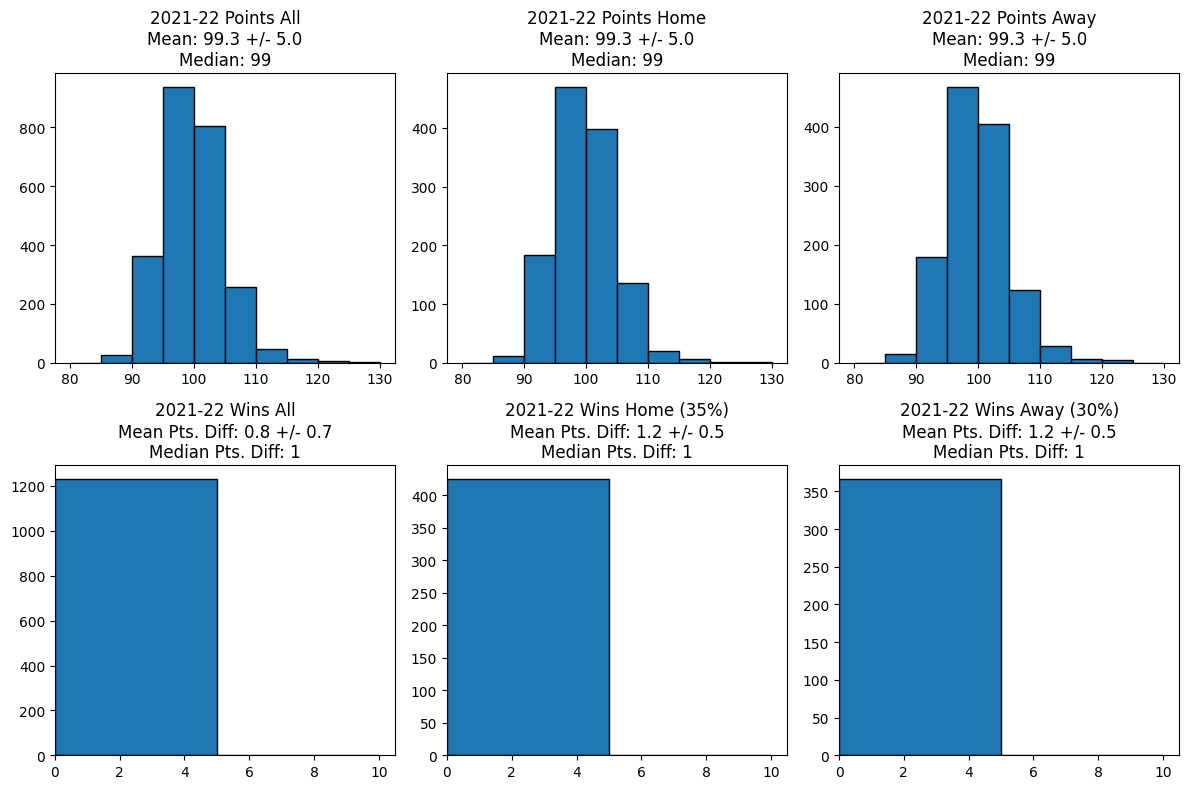


Number of games: 1230
t-Statistic: -1.682; p-value: 0.093
Cohen's d (effect): -0.048


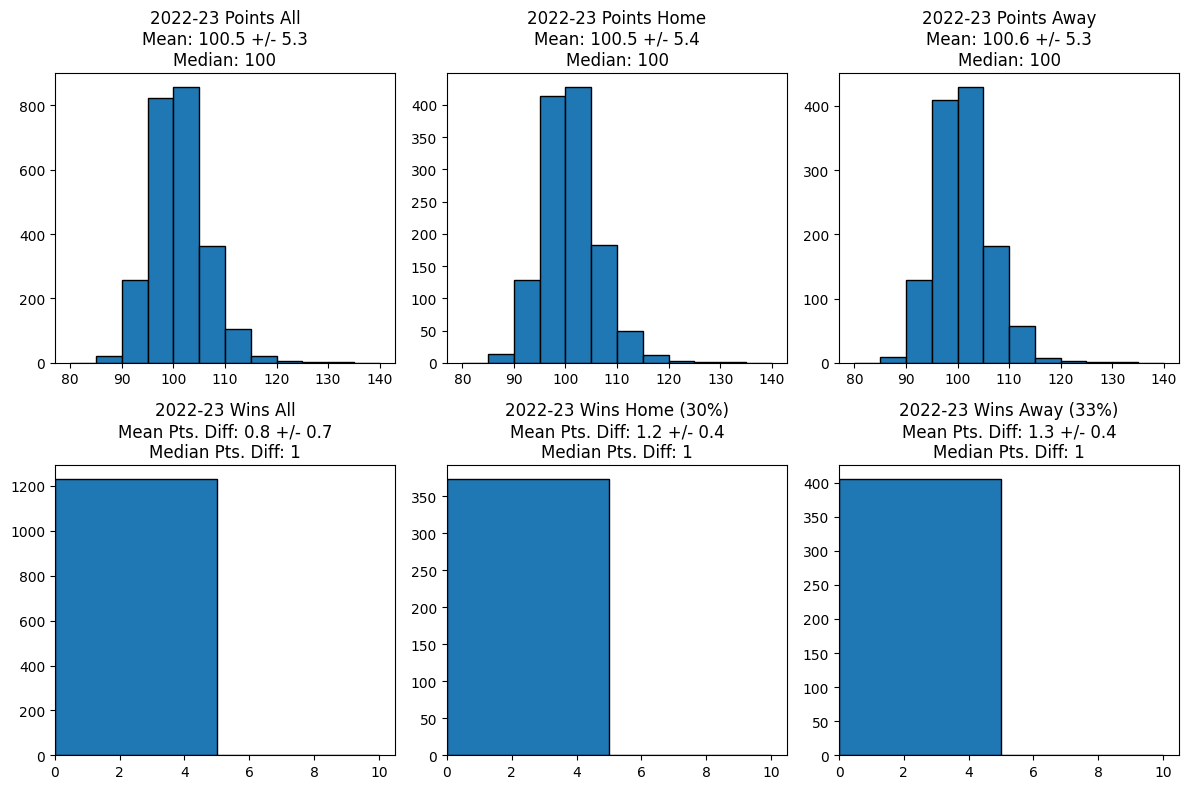


Number of games: 1230
t-Statistic: -0.986; p-value: 0.325
Cohen's d (effect): -0.028


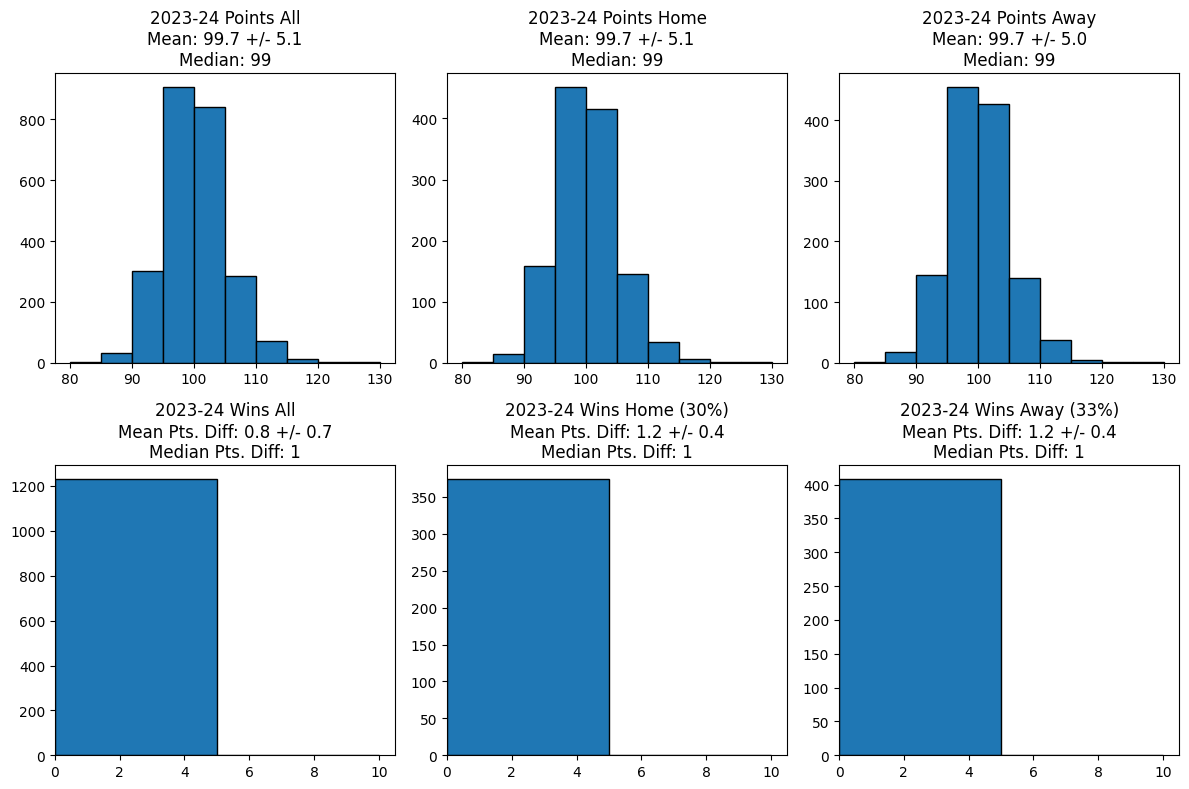


Number of games: 1230
t-Statistic: 0.407; p-value: 0.684
Cohen's d (effect): 0.012


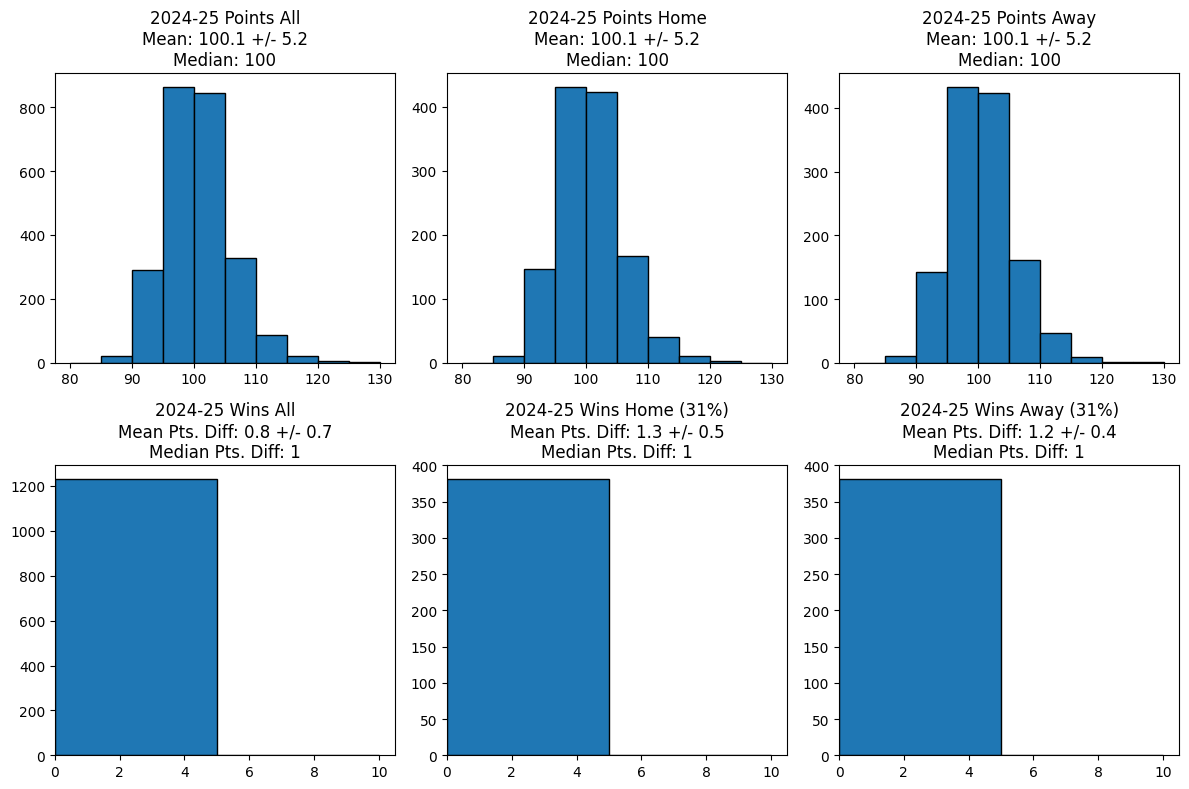


Number of games: 28
t-Statistic: -0.398; p-value: 0.693
Cohen's d (effect): -0.075


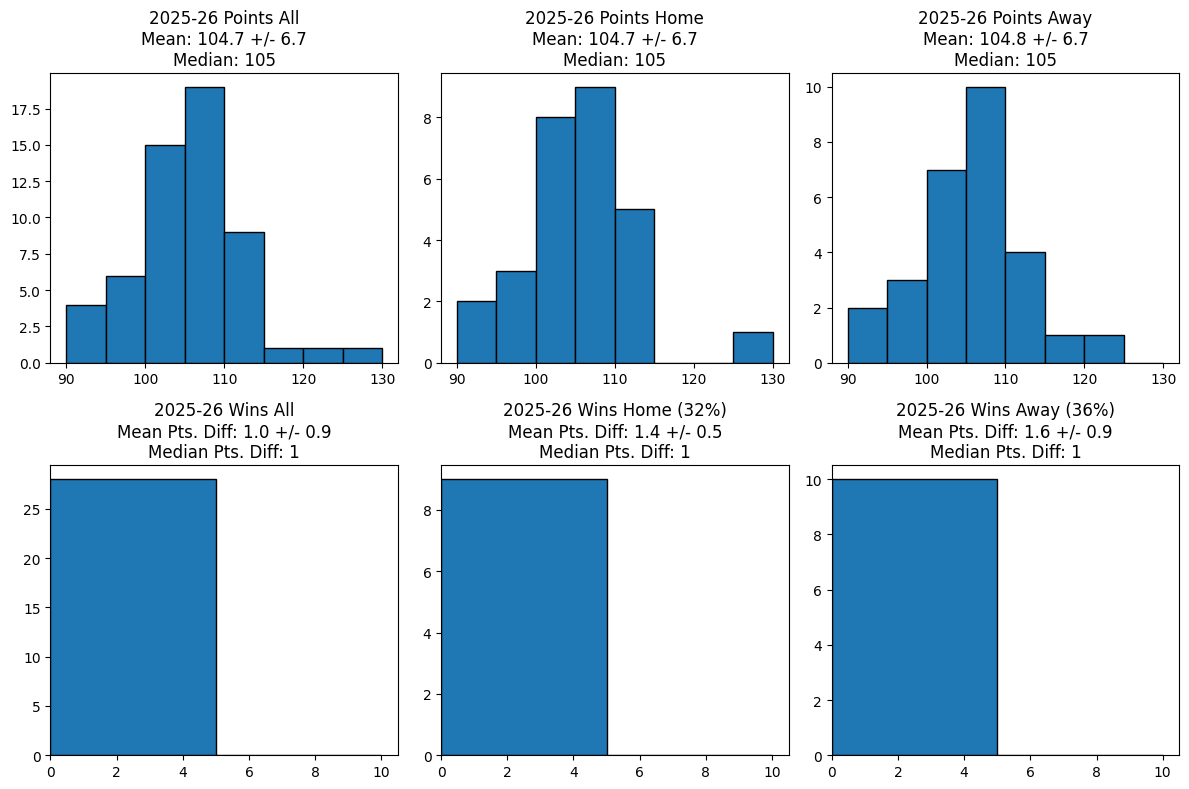

In [3]:
# A describe().T with season_all, season_home, season_away as the index
# Each one will probably have to be independently calculated and appended
import math as m
import matplotlib.pyplot as plt
import numpy as np

df_dict = {}

for season in seasons:
    schema = season_conversion(season)
    # Query data
    sch = pd.read_sql_query(f"""select *
                            from "{schema}".game_details where home_pts is not null
                            and game_id != '0062400001'
                            """,con=c_eng)
    sch = sch[ (sch["game_type"]=="Regular Season") | (sch["game_type"]=="Emirates NBA Cup") ]
    sch.sort_values("game_time",inplace=True)    # Sort by date, preserve time order
    df_dict[schema] = sch  
    print(f"Number of games: {len(sch)}")
    
    stat_list = []
    home_list = []
    away_list = []

    for game in sch.index:
        # Event-dependent assignments
        home_stat = sch.loc[game,"home_pos"]               # Assign home
        away_stat = sch.loc[game,"away_pos"]               # Assign away

        home_list.append(home_stat)
        away_list.append(away_stat)
        stat_list.append(home_stat)     # For 
        stat_list.append(away_stat)

    max_stat = max(stat_list)
    min_stat = min(stat_list)
    
    limit_low = m.floor(min_stat/10) * 10
    limit_high = m.ceil(max_stat/10) * 10
    bins = int((limit_high - limit_low) / 5)

    # Test for significance between home/away means
    # Paired t-test, so difference is measured at every i-position in each list
    # Since the mean of differences is divided by std of differences, small std can make t-statistic large
    from scipy.stats import ttest_rel
    t_stat, p_val = ttest_rel(home_list, away_list)
    print(f"t-Statistic: {t_stat:.3f}; p-value: {p_val:.3f}")
    
    # Effect size
    # Cohen's d measures practical significance small < .2 < .6 < .8 < big
    # How many stds apart the means are
    diffs = np.array(home_list) - np.array(away_list)
    cohens_d = np.mean(diffs) / np.std(diffs, ddof=1)
    print(f"Cohen's d (effect): {cohens_d:.3f}")
    
    # Plot histograms
    fig, axes = plt.subplots(2, 3, figsize=(12,8))
    axes[0, 0].hist(stat_list,
                 range=[limit_low, limit_high],
                 bins=bins,
                 edgecolor="black",
                 linewidth=1)
    axes[0, 0].set_title(f"{season} Points All\nMean: {round(np.mean(stat_list),1)} +/- {round(np.std(stat_list),1)}\nMedian: {int(np.median(stat_list))}")
    
    axes[0, 1].hist(home_list,
                 range=[limit_low, limit_high],
                 bins=bins,
                 edgecolor="black",
                 linewidth=1)
    axes[0, 1].set_title(f"{season} Points Home\nMean: {round(np.mean(home_list),1)} +/- {round(np.std(home_list),1)}\nMedian: {int(np.median(home_list))}")
  
    axes[0, 2].hist(away_list,
                 range=[limit_low, limit_high],
                 bins=bins,
                 edgecolor="black",
                 linewidth=1)
    axes[0, 2].set_title(f"{season} Points Away\nMean: {round(np.mean(away_list),1)} +/- {round(np.std(away_list),1)}\nMedian: {int(np.median(away_list))}")  

    # Wins
    # Each row is at the game-level, meaning there is a win in each row
    # The calculation is home - away, so away wins will always be negative
    # This returns point differential for all wins
    all_wins = [abs(val) for val in diffs] 
    max_wins = max(all_wins)
    min_wins = min(all_wins)
    
    limit_low = m.floor(min_wins/10) * 10
    limit_high = m.ceil(max_wins/10) * 10
    bins = int((limit_high - limit_low) / 5)
    
    axes[1, 0].hist(all_wins,
                 range=[0, limit_high],
                 bins=bins,
                 edgecolor="black",
                 linewidth=1)
    axes[1, 0].set_title(f"{season} Wins All\nMean Pts. Diff: {round(np.mean(all_wins),1)} +/- {round(np.std(all_wins),1)}\nMedian Pts. Diff: {int(np.median(all_wins))}")
    axes[1, 0].set_xlim(left=0)

    home_wins = [abs(val) for val in diffs if val > 0]
    h_win_p = int(round(100 * len(home_wins) / len(all_wins), 0))
    axes[1, 1].hist(home_wins,
                 range=[0, limit_high],
                 bins=bins,
                 edgecolor="black",
                 linewidth=1)
    axes[1, 1].set_title(f"{season} Wins Home ({h_win_p}%)\nMean Pts. Diff: {round(np.mean(home_wins),1)} +/- {round(np.std(home_wins),1)}\nMedian Pts. Diff: {int(np.median(home_wins))}")
    axes[1, 1].set_xlim(left=0)
  
    away_wins = [abs(val) for val in diffs if val < 0]
    a_win_p = int(round(100 * len(away_wins) / len(all_wins), 0))
    axes[1, 2].hist(away_wins,
                 range=[0, limit_high],
                 bins=bins,
                 edgecolor="black",
                 linewidth=1)
    axes[1, 2].set_title(f"{season} Wins Away ({a_win_p}%)\nMean Pts. Diff: {round(np.mean(away_wins),1)} +/- {round(np.std(away_wins),1)}\nMedian Pts. Diff: {int(np.median(away_wins))}")
    axes[1, 2].set_xlim(left=0)
    
    plt.tight_layout()
    plt.show()

    
    print()

In [40]:
sch.columns

Index(['game_id', 'home_id', 'away_id', 'game_time', 'game_type', 'periods',
       'officials', 'duration', 'lead_changes', 'home_pos', 'home_pts',
       'away_pts', 'home_pitp_a', 'home_pitp_m', 'away_pitp_a', 'away_pitp_m',
       'home_bench_pts', 'away_bench_pts', 'home_fb_pts', 'away_fb_pts',
       'home_pts_from_to', 'away_pts_from_to', 'home_longest_run',
       'away_longest_run', 'home_2nd_chance_pts', 'away_2nd_chance_pts',
       'home_technical_fouls', 'away_technical_fouls', 'away_pos'],
      dtype='object')

In [ ]:
# Parse officials to their own columns
def ref_check(x):
    id = x["game_id"]
    refs = [ref for ref in x["officials"].split("_")]
    if len(refs) != 3:   # Only once in last four seasons did this not occur
        refs.pop()
        #print(id, refs)
    return refs
    

for key in df_dict.keys():
    df = df_dict[key]
    ref_cols = ["r1", "r2", "r3"]
    df[ref_cols] = df[["game_id", "officials"]].apply(lambda x: pd.Series(ref_check(x)), axis=1)

    #print(df[ref_cols].isna().sum())
    

In [64]:
pd.options.mode.chained_assignment = None

refs_dict = {}

refs = ["game_id", "home_id", "home_pts", "away_id", "away_pts"] + ref_cols
for season in df_dict.keys():
    refs_dict[season] = df_dict[season][refs]
    refs_dict[season]["total_pts"] = refs_dict[season]["home_pts"] + refs_dict[season]["away_pts"]
    print(refs_dict[season].head())
    

         game_id     home_id  home_pts     away_id  away_pts  \
528   0022100001  1610612749       127  1610612751       104   
1319  0022100002  1610612747       114  1610612744       121   
523   0022100004  1610612765        88  1610612741        94   
1221  0022100003  1610612766       123  1610612754       122   
524   0022100005  1610612752       138  1610612738       134   

                    r1            r2               r3  total_pts  
528         Josh Tiven  Natalie Sago      Jacyn Goble        231  
1319       Sean Wright  Mark Lindsay       Ray Acosta        235  
523   Derek Richardson    Tyler Ford     Mousa Dagher        182  
1221       Rodney Mott    Scott Wall       Nate Green        245  
524       Scott Foster     Ed Malloy  Lauren Holtkamp        272  
         game_id     home_id  home_pts     away_id  away_pts             r1  \
525   0022200001  1610612738       126  1610612755       117   James Capers   
1220  0022200002  1610612744       123  1610612747     

In [ ]:


# By season, create line charts of median vs mean grouped by game #
# Drop the cup championship game 0062400001


dict_keys(['202122', '202223', '202324', '202425'])